In [2]:
import utils
import gaussian_cal
import pandas as pd
import subprocess
import os
import time
from rdkit.Chem import PandasTools
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from rdkit import Chem
from rdkit.Chem import AllChem

**基础数据**

In [ ]:
name_list = ['S','A','EHOPA','AEPYridine','AEP','APN','DBE','DIPEDA','OA','mXD']
smiles_list = [
'FC1(C(F)(C(F)(F)F)F)C(OC(F)(F)C(F)1F)(C(F)(C(F)(F)F)F)F',
'FC1(C(F)(C(F)(F)F)F)C(OC(F)(F)C(F)1F)(C(F)(C(O)=O)F)F',
'CCCCC(CC)COCCCNC(C(F)(F)C1(F)OC(F)(F)C(F)(F)C1(C(F)(C(O)=O)F)F)=O',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCC2=CN=CC=C2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN2CCCCC2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NC2=CC(C#N)=CC(C#N)=C2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN(CCCC)CCCC)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN(C(C)C)C(C)C)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCCCCCCC)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCC2=CC(CN)=CC=C2)=O)F)O1',
]
P_sp = {'S':0.135,'A':0.211,'EHOPA':0.686,'AEPYridine':0.855,'AEP':0.862,
        'APN':0.558,'DBE':0.746,'DIPEDA':0.715,'OA':0.576,'mXD':0.959,}
IP_PCM = {'EHOPA':7.38,'AEPYridine':7.63,'AEP':6.18,'APN':8.18,'DBE':6.27,
        'DIPEDA':6.21,'OA':8.15,'mXD':6.78,'S':11.32,'A':9.73,}
N_sp = {'S':0.088,'A':0.237,'EHOPA':0.5,'AEPYridine':0.875,'AEP':0.815,
        'APN':0.409,'DBE':0.676,'DIPEDA':0.592,'OA':0.481,'mXD':0.954,}
EA_PCM = {'EHOPA':2.28,'AEPYridine':2.43,'AEP':2.53,'APN':3.22,'DBE':3.27,
        'DIPEDA':2.23,'OA':2.24,'mXD':4.35,'S':3.52,'A':4.39,}
psp_Mao = np.array([P_sp[i] for i in name_list])
nsp_Mao = np.array([N_sp[i] for i in name_list])
ip_pcm_Mao = np.array([IP_PCM[i] for i in name_list])
ea_pcm_Mao = np.array([EA_PCM[i] for i in name_list])


**根据smiles表达式生成分子的xyz文件**

In [3]:
for i in range(len(name_list)):
    for j in range(5):
        utils.smile2xyz(name_list[i]+str(j)+'_0.xyz',smiles_list[i],randomSeed=None)

**计算方法，计算基组**

In [3]:
method = 'CAM-B3LYP'
basis = '6-31G(d,p)'
PCM = 'True'
EPS = 2.05
iteration = 5
debug = True

In [ ]:
G0 = gaussian_cal.GaussianCal(method=method,basis=basis,charge='neu',wfn=True,debug=debug,PCM=PCM,EPS=EPS)
G1 = gaussian_cal.GaussianCal(method=method,basis=basis,charge='pos',wfn=True,debug=debug,PCM=PCM,EPS=EPS)

for i in range(len(name_list)):
    for j in range(iteration):
        if os.path.exists(f"{name_list[i]}{j}"):
            if debug:
                while utils.i8cpu_running():
                    time.sleep(60)
            G0.Run(f"{name_list[i]}{j}_0.xyz")
            if debug:
                while utils.i8cpu_running():
                    time.sleep(60)
            G1.Run(f"{name_list[i]}{j}_0.xyz")

**Result Analysis**

In [11]:
def data_to_csv(prop,prop_calculation):
    names = locals()
    names[prop],names[f'{prop}_name'] = [],[]
    for _ in tqdm(name_list):
        for i in range (200):
            if os.path.exists(f"{_}{i}"):
                names[prop].append(float("{:.3f}".format((prop_calculation((f"{_}{i}"))))))
                names[f'{prop}_name'].append(f"{_}{i}")

    column_name = [f'Name_{prop}(eV)', f'{method}_{basis}_PCM' if PCM else f'{method}_{basis}_Gas']
    table = pd.DataFrame({column_name[0]: names[f'{prop}_name'], column_name[1]: names[prop]})
    table.to_csv(f'{method}_{basis}_PCM_{prop}' if PCM else f'{method}_{basis}_Gas_{prop}', index=False)
    df = table.drop([f'Name_{prop}(eV)'], axis=1)
    try:
        reshaped_data = df[ f'{method}_{basis}_PCM' if PCM else f'{method}_{basis}_Gas'].values.reshape(10, 10).T
    except:
        reshaped_data = df[ f'{method}_{basis}_PCM' if PCM else f'{method}_{basis}_Gas'].values.reshape(10, 5).T
    new_df = pd.DataFrame(reshaped_data, columns=[f'{name_list[i]}' for i in range(10)])
    new_df.to_csv(f'{method}_{basis}_PCM_{prop}.csv' if PCM else f'{method}_{basis}_Gas_{prop}.csv', index=False)
    return new_df
def data_wash(df):
    df.replace()
    df.replace(0, np.nan, inplace=True)
    mean_values = df.mean()
    df.fillna(mean_values, inplace=True)
    return df
def data_mean_std(df):
    mean_values = df.mean().round(3)
    std_values = df.std().round(3)
    df.loc['mean'] = mean_values
    df.loc['std'] = std_values
    return df
def corrcoef(df):
    for i in range(len(df)):
        random = np.array(df.iloc[i].tolist())
        print(round(np.corrcoef(random,psp_Mao)[0,1]),3)
    mean = np.array(round(df.mean(),3).tolist())
    median = np.array(round(df.median(),3).tolist())
    print('mean',np.corrcoef(mean,psp_Mao)[0,1])
    print('median',np.corrcoef(median,psp_Mao)[0,1])
    return mean

In [12]:
df_IP = data_to_csv('IP',utils.IP_calculation)
df_IP = data_wash(df_IP)
df_IP

100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


,EHOPA,AEPYridine,AEP,APN,DBE,DIPEDA,OA,mXD
0,8.0900,7.959,6.822,8.147,6.796,6.987,8.309,7.723
1,8.0770,8.174,6.967,8.146,6.971,6.707,8.279,7.442
2,8.0820,8.172,6.967,8.148,6.563,6.668,8.285,7.441
3,8.0490,8.035,7.126,8.147,6.901,6.641,8.296,7.634
4,8.0745,8.034,6.755,8.151,6.949,6.907,8.330,7.577


In [13]:
df_HOMO = data_to_csv('HOMO',utils.HOMO_calculation)
df_HOMO = data_wash(df_HOMO)
df_HOMO = data_mean_std(df_HOMO)
df_HOMO


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


In [14]:
HOMO_mean,HOMO_median = corrcoef(df_HOMO)

-0.4128545754436086
-0.4119556824428409
-0.3704614991595833
-0.34933562787025757
-0.45894815123763905
mean -0.40461955003387384
median -0.3989120290485083


In [65]:
plt.rcdefaults()

def prop_charge(x, y, title='None',xlabel = 'None',ylabel = 'None'):
    # 示例形状和标签
    shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
    labels = [f'{name_list[i]}' for i in range(len(x))]
    co = round(np.corrcoef(x, y)[0,1],3)
    # 创建散点图并指定不同的形状和标签
    plt.figure(figsize=(6, 6))
    plt.tick_params(axis='both', direction='in', which='both')
    plt.grid(linestyle='-.')
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
    # 添加图例
    if co < 0:
        plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), ncol=2, title="CYTOP")
    else:
        plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")

    # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
    # 设置图形标题和坐标轴标签
    plt.title(f"Correlation Coefficient: {co}",fontsize=15,fontweight='bold')
    plt.xlabel(xlabel,fontsize=12,fontweight='bold')
    plt.xticks(fontsize=10)  # X轴刻度字体大小
    plt.yticks(fontsize=10) 
    plt.ylabel(ylabel,fontsize=12,fontweight='bold')
    if max(y) < 1:
        plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(title,dpi=300)
    # 显示图形
    plt.show()

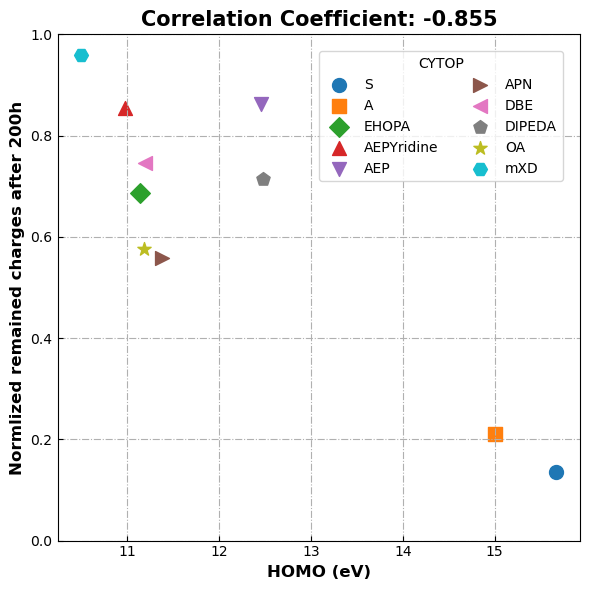

In [86]:
prop_charge(HOMO_mean,
              psp_Mao,
              title='CC_HOMO_psp',
              xlabel = 'HOMO (eV)',
              ylabel = 'Normlized remained charges after 200h' )


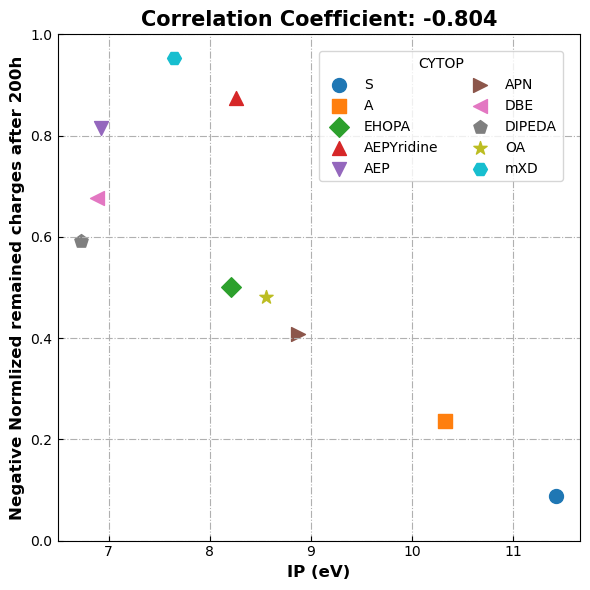

In [101]:
prop_charge(IP_mean,
              nsp_Mao,
              title='CC_IP_nsp',
              xlabel = 'IP (eV)',
              ylabel = 'Negative Normlized remained charges after 200h' )


In [83]:
plt.rcdefaults()

def prop_com(x, y,title='None',xlabel = 'None',ylabel = 'None'):
    # 示例形状和标签
    shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
    labels = [f'{name_list[i]}' for i in range(len(x))]
    co = round(np.corrcoef(x, y)[0,1],3)
    # 创建散点图并指定不同的形状和标签
    plt.figure(figsize=(6, 6))
    plt.tick_params(axis='both', direction='in', which='both')
    plt.plot([min(min(x),min(y)),max(max(x),max(y))],[min(min(x),min(y)),max(max(x),max(y))],linestyle='--',color='black')
    plt.grid(linestyle='-.')
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
    # 添加图例
    if co < 0:
        plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), ncol=2, title="CYTOP")
    else:
        plt.legend(loc='lower right', bbox_to_anchor=(0.98, 0.02), ncol=2, title="CYTOP")
    # 设置图形标题和坐标轴标签
    plt.title(f"Correlation Coefficient: {co}",fontsize=15,fontweight='bold')
    plt.xlabel(xlabel,fontsize=12,fontweight='bold')
    plt.xticks(fontsize=10)  # X轴刻度字体大小
    plt.yticks(fontsize=10) 
    plt.ylabel(ylabel,fontsize=12,fontweight='bold')
    plt.tight_layout()
    plt.savefig(title,dpi=300)
    # 显示图形
    plt.show()

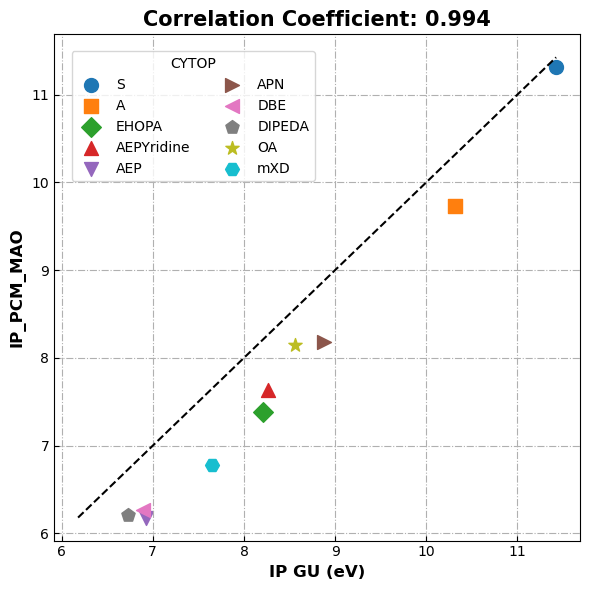

In [72]:
prop_com(IP_mean,
        ip_pcm_Mao,
        title='CC_IP(GU)_IP(MAO)',
        xlabel = 'IP GU (eV)',
        ylabel = 'IP_PCM_MAO(eV)' )


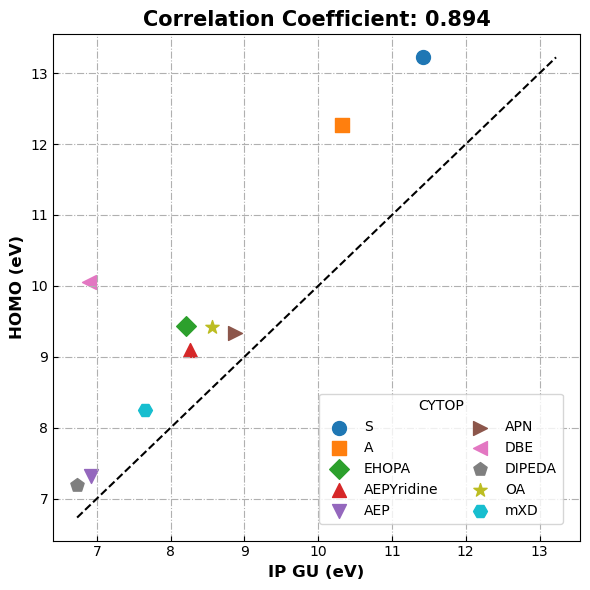

In [100]:
prop_com(IP_mean,
        HOMO_mean,
        title='CC_IP(GU)_HOMO',
        xlabel = 'IP GU (eV)',
        ylabel = 'HOMO (eV)' )


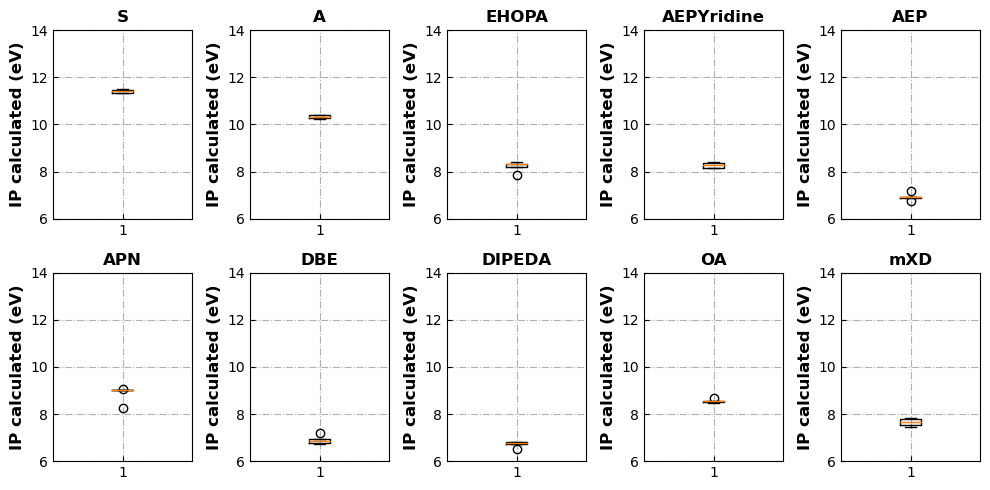

In [28]:

# 示例数据，替换为你的IP值数据
# 统计描述

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.boxplot(df_IP.iloc[:,i], vert=True)  # 绘制箱型图
    ax.set_ylabel('IP calculated (eV)',fontsize=12,fontweight='bold')
    ax.grid(linestyle='-.')
    ax.tick_params(axis='both', direction='in')  # 'both'表示x和y轴都调整
    ax.set_ylim(6,14)
    ax.set_title(f'{name_list[i]}',fontsize=12,fontweight='bold')
plt.tight_layout()
plt.savefig('CYTOP_camb3lyp-631(dp)_IP_rdkit.png', dpi=300)

plt.show()


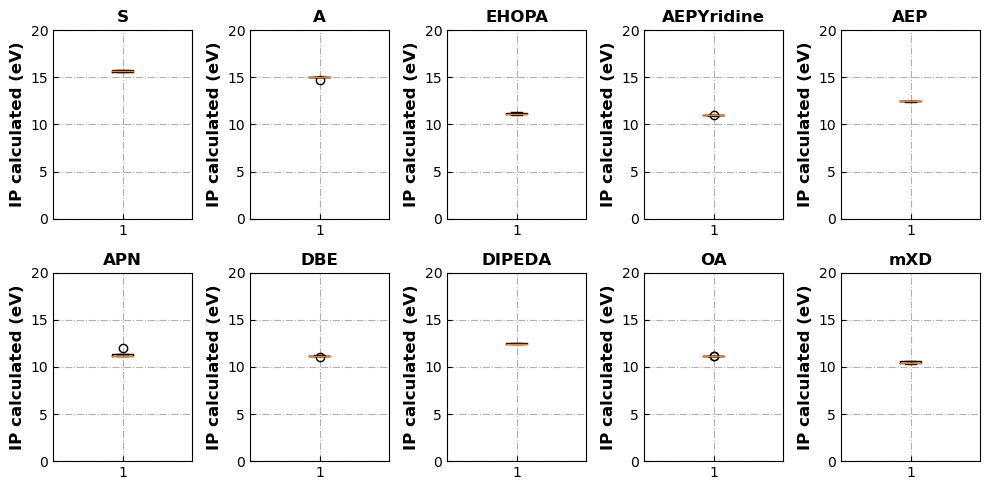

In [89]:
# 示例数据，替换为你的IP值数据
# 统计描述

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.boxplot(df_HOMO.iloc[:,i], vert=True)  # 绘制箱型图
    ax.set_ylabel('IP calculated (eV)',fontsize=12,fontweight='bold')
    ax.grid(linestyle='-.')
    ax.tick_params(axis='both', direction='in')  # 'both'表示x和y轴都调整
    ax.set_ylim(0,20)
    ax.set_title(f'{name_list[i]}',fontsize=12,fontweight='bold')
plt.tight_layout()
# plt.savefig('CYTOP_camb3lyp-631(dp)_IP_rdkit.png', dpi=300)

plt.show()

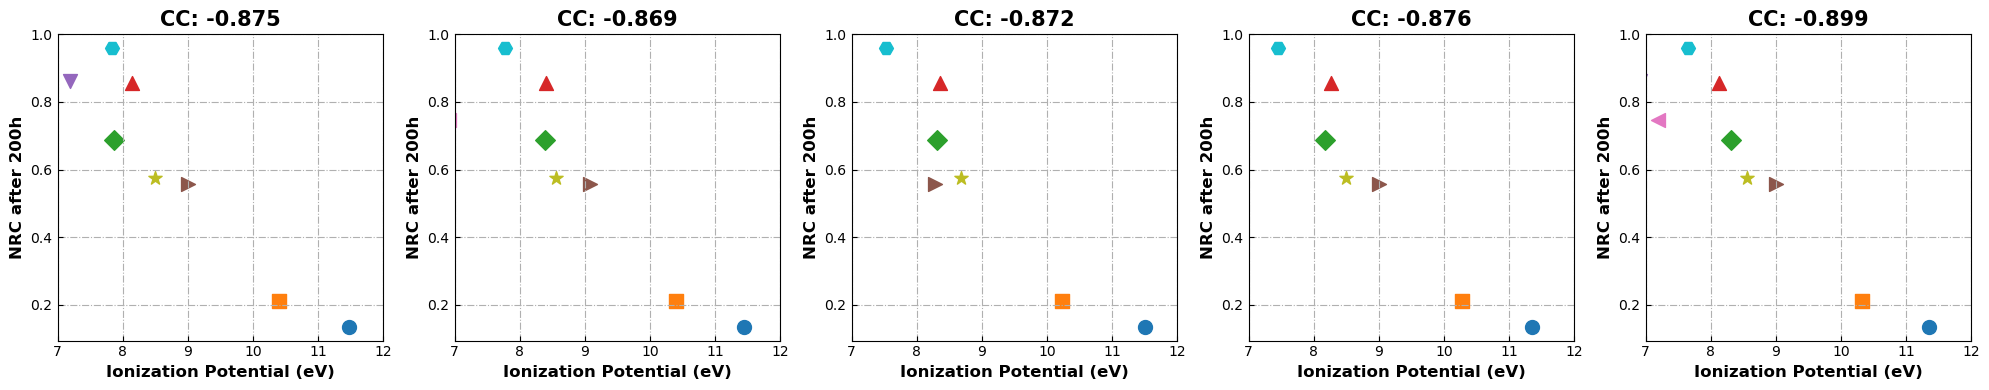

<Figure size 640x480 with 0 Axes>

In [30]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# 示例形状和标签
shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']

for j, ax in enumerate(axes.ravel()):
    if j < len(name_list):
        # 创建散点图并指定不同的形状和标签
        shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
        labels = [f'{name_list[i]}' for i in range(10)]
        co = round(np.corrcoef(rdkit_df.iloc[j,:], psp)[0,1],3)
        # 创建散点图并指定不同的形状和标签
        ax.tick_params(axis='both', direction='in', which='both')
        ax.grid(linestyle='-.')
        for i in range(10):
            ax.scatter(rdkit_df.iloc[j,:][i], psp[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
        # 添加图例
        # plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")
        # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
        # 设置图形标题和坐标轴标签
        ax.set_title(f"CC: {co}",fontsize=15,fontweight='bold')
        ax.set_xlabel("Ionization Potential (eV)",fontsize=12,fontweight='bold')     
        ax.tick_params(axis='both', direction='in', which='both')
        ax.set_xlim(7,12)
        ax.set_ylabel("NRC after 200h",fontsize=12,fontweight='bold')
plt.tight_layout()
# 显示图形
plt.savefig('random.png',dpi=300)
plt.show()

# 调整子图之间的间距
plt.tight_layout()

In [32]:
# T1,T2,T_all = [],[],[]
# time_dict = {}
# for _ in name_list:
#     for i in range(10):
#         if os.path.exists(f"{_}{i}"):
#             t1 = utils.time_calculation(f"{_}{i}/{_}{i}_p1.log")
#             t2 = utils.time_calculation(f"{_}{i}/{_}{i}_0.log")
#             print(t1/t2)
#             T1.append(t1)
#             T2.append(t2)
#             T_all.append(t1+t2)

table = pd.DataFrame({'Name': IP_name, 'T':T_all})
table
# table.to_csv('CYTOP_m062x_6-311G(2d,p)_time.csv', index=False)
df = table.drop(['Name'], axis=1)
reshaped_data = df['T'].values.reshape(10, 5).T
new_df = pd.DataFrame(reshaped_data, columns=[f'{name_list[i]}' for i in range(10)])
new_df.to_csv('camb3lyp_IP_time.csv', index=False)
rdkit_T_df = new_df
rdkit_T_df

,S,A,EHOPA,AEPYridine,AEP,APN,DBE,DIPEDA,OA,mXD
0,27.110000,25.350000,80.106667,51.711667,46.271667,61.338333,60.561667,52.848333,69.038333,60.103333
1,23.351667,24.660000,78.045000,56.465000,44.761667,58.305000,66.895000,63.956667,212.008333,58.328333
2,27.551667,24.276667,76.508333,55.971667,46.473333,53.051667,66.343333,58.866667,61.801667,57.173333
3,25.728333,25.051667,72.151667,55.833333,45.035000,65.015000,71.431667,55.770000,74.100000,67.555000
4,25.693333,25.000000,74.568333,52.258333,45.430000,58.948333,81.055000,54.565000,211.921667,74.046667


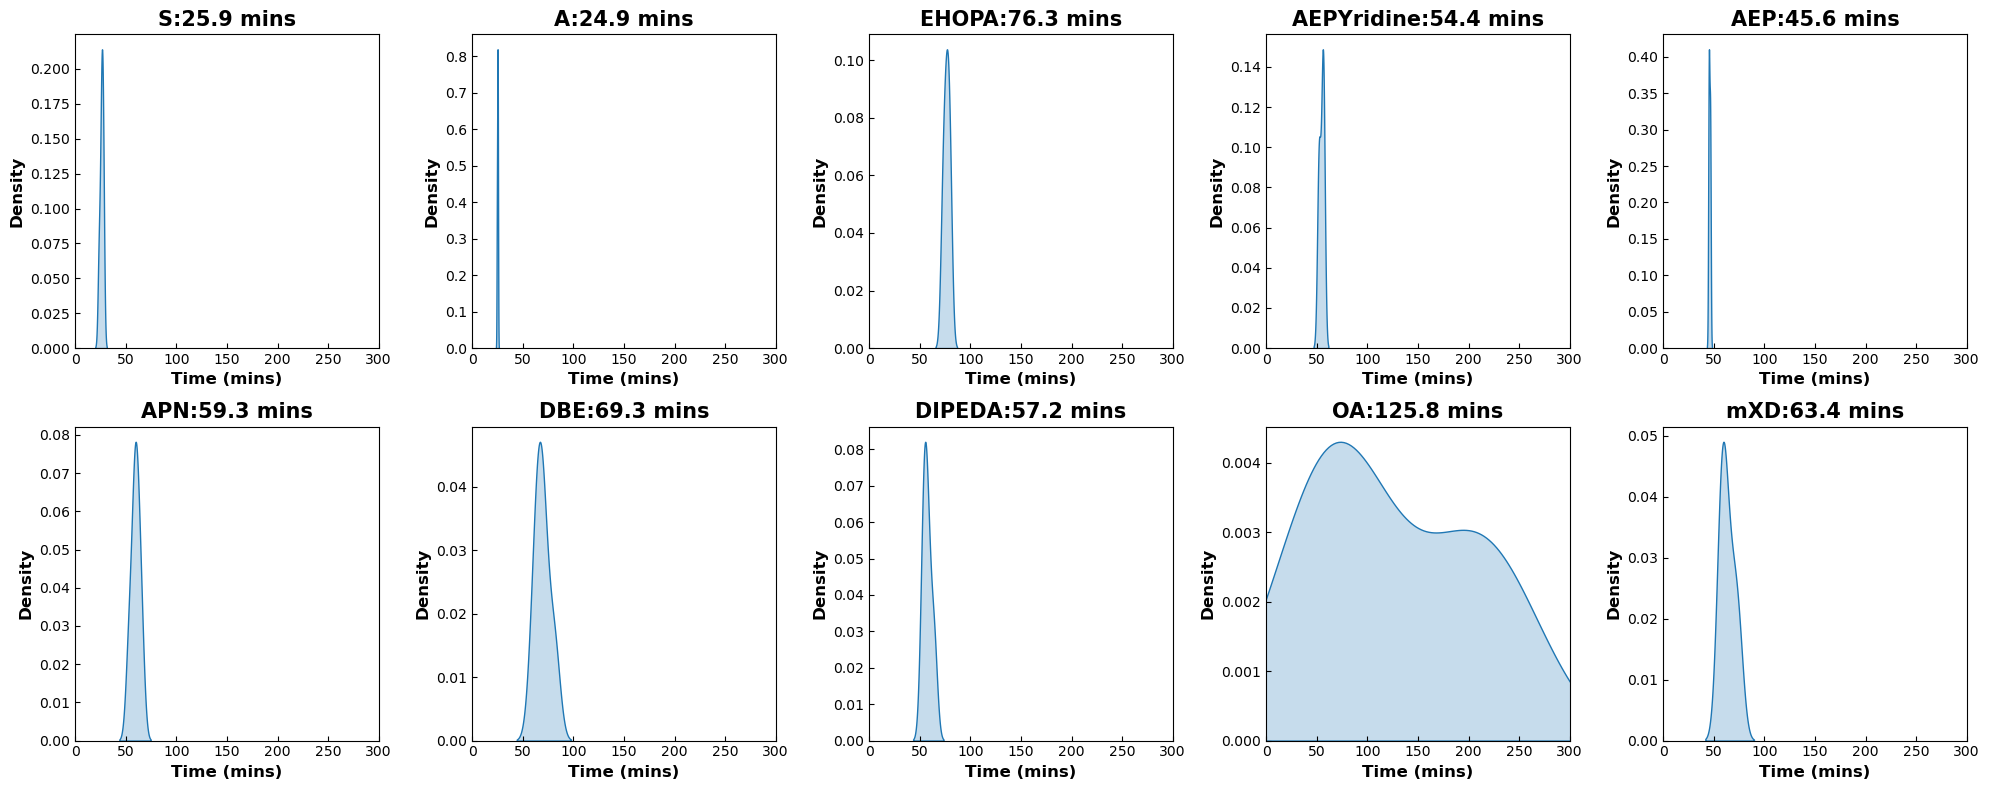

In [33]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# 示例形状和标签

for j, ax in enumerate(axes.ravel()):
    time = round(rdkit_T_df.mean()[j],1)
    if j < len(name_list):
        sns.kdeplot(rdkit_T_df.iloc[:,j], fill=True,ax=ax)
        # 添加图例
        # plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")
        # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
        # 设置图形标题和坐标轴标签
        ax.set_title(f"{name_list[j]}:{time} mins",fontsize=15,fontweight='bold')
        ax.set_xlabel("Time (mins)",fontsize=12,fontweight='bold')     
        ax.tick_params(axis='both', direction='in', which='both')
        ax.set_xlim(0,300)
        ax.set_ylabel("Density",fontsize=12,fontweight='bold')
plt.tight_layout()
# 显示图形
plt.savefig('Time_Density.png',dpi=300)
plt.show()

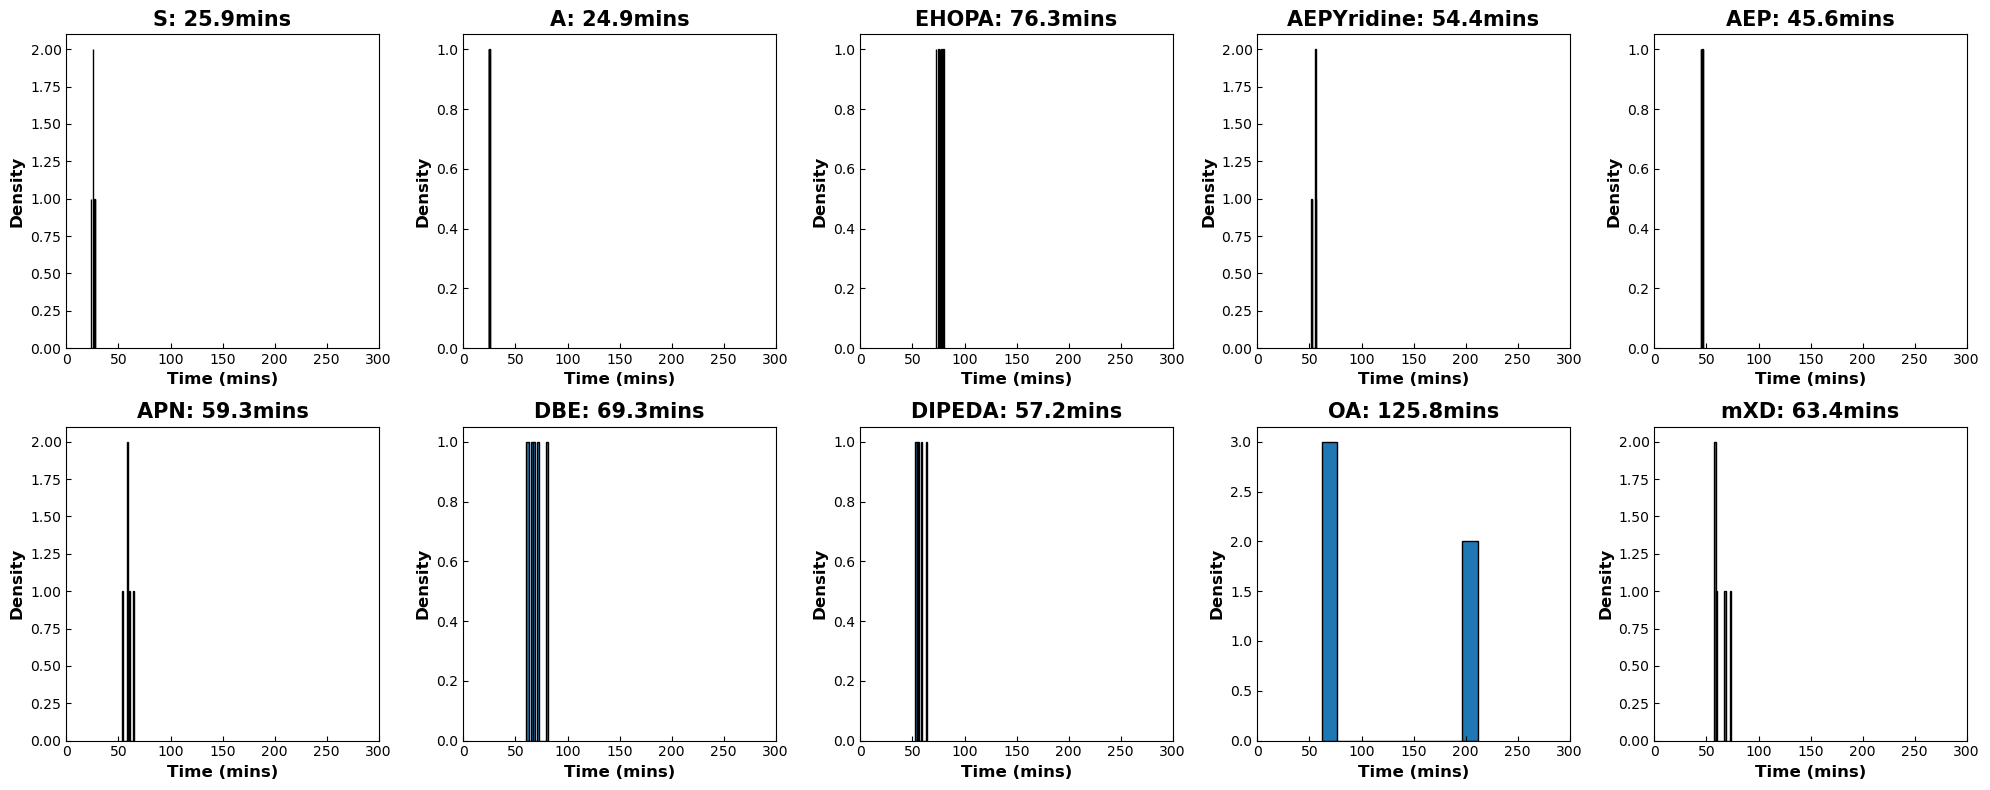

In [34]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# 示例形状和标签

for j, ax in enumerate(axes.ravel()):
    time = round(rdkit_T_df.mean()[j],1)
    if j < len(name_list):
        ax.hist(rdkit_T_df.iloc[:,j], bins=10, edgecolor='k')

        # 添加图例
        # plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")
        # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
        # 设置图形标题和坐标轴标签
        ax.set_title(f"{name_list[j]}: {time}mins",fontsize=15,fontweight='bold')
        ax.set_xlabel("Time (mins)",fontsize=12,fontweight='bold')     
        ax.tick_params(axis='both', direction='in', which='both')
        ax.set_xlim(0,300)
        ax.set_ylabel("Density",fontsize=12,fontweight='bold')
plt.tight_layout()
# 显示图形
plt.savefig('Time_hist.png',dpi=300)
plt.show()